In [1]:
import numpy as np
import networkx as nx
from utilities import random_expander_edges, kendall_tau, random_cycle, edges_from_cycle
import matplotlib.pyplot as plt
from typing import Literal
from itertools import  pairwise

plt.style.use('_mpl-gallery')

## Is PageRank surjective?

We want to know whether any vote order is possible with the PageRank. The constraint is that the graph is sparse (small regular expander)

In [2]:
# Number of samples
N = 40

data = [(n := np.random.randint(100,1500), list(np.random.permutation(n))) for i in range(N)]

In [12]:
def mimic_ranking(G: nx.DiGraph, edges: list, ranking: list):
    """ Create a graph that mimics a given ranking: for any edge (a,b) in the list, add arrow (a,b) if b is ranked higher than a, and (b,a) otherwise"""

    ordered_edges = []
    for u, v in edges:
        if ranking.index(u) < ranking.index(v):
            ordered_edges.append((u, v))
        else:
            ordered_edges.append((v, u))
    G.add_edges_from(ordered_edges)
    return G


def apply_page_rank(G):
    # Compute PageRank
    pr = nx.pagerank(G)
    # Sort entries with decreasing score
    sorted_entries = sorted(list(pr.items()), key=lambda e: e[1])
    # Return the sorted entries numbers
    return list(map(lambda x: x[0], sorted_entries))


def create_graph(degree, size, ranking, graph_strategy: Literal["expander", "random_regular", "recursive_pr", "recursive_pr2"]):
    assert degree % 2 == 0, "The degree must be even"

    G = nx.DiGraph()
    G.add_nodes_from(range(size))

    if graph_strategy == "expander":
        edges = random_expander_edges(degree // 2, size)
        G = mimic_ranking(G, edges, ranking)
    elif graph_strategy == "random_regular":
        edges = list(nx.generators.random_graphs.random_regular_graph(degree, size).edges())
        G = mimic_ranking(G, edges, ranking)
    elif graph_strategy == "recursive_pr":
        # Start with random cycle
        edges = edges_from_cycle(random_cycle(size))
        G = mimic_ranking(G, edges, ranking)
        # Iteratively compute the page rank, and create new cycles of votes
        for _ in range(degree // 2 - 1):
            edges = edges_from_cycle(apply_page_rank(G))
            G = mimic_ranking(G, edges, ranking)
    elif graph_strategy == "recursive_pr2":
        # Start with random cycle
        edges = edges_from_cycle(random_cycle(size))
        G = mimic_ranking(G, edges, ranking)
        # Iteratively compute the page rank, and create new cycles of votes
        for i in range(degree // 2 - 1):
            pr = nx.pagerank(G)
            sorted_entries = sorted(list(pr.items()), key=lambda e: e[1])
            cycles = [[] for _ in range(2**i)]
            # Create cycles of same score entries
            for idx,v in sorted_entries:
                j = round(2**(i-1) * v)
                cycles[j].append(idx)
            for cycle in cycles:
                if len(cycle) > 1:
                    edges = edges_from_cycle(cycle)
                    G = mimic_ranking(G, edges, ranking)
    else:
        raise NotImplementedError("This strategy does not exist")

    return G

In [4]:
def apply_ranking_strategy(degree, graph_strategy: Literal['expander', "random_regular", 'recursive_pr'], ranking_strategy: Literal["page_rank"]):
  values = [create_graph(degree, n, L, graph_strategy) for n,L  in data ]

  if ranking_strategy =="page_rank":
    final_ranking = [apply_page_rank(G) for G in values]
  else:
    raise NotImplementedError("Ranking strategy not implemented")

  return [kendall_tau(rank, computed_rank) for rank, computed_rank in zip([L for _,L in data], final_ranking)]

In [5]:
DEGREE = 6
x = [n for n,_ in data]
y1 = apply_ranking_strategy(DEGREE, graph_strategy="expander", ranking_strategy="page_rank")
y2 = apply_ranking_strategy(DEGREE, graph_strategy="random_regular", ranking_strategy="page_rank")

In [6]:
y3 = apply_ranking_strategy(10, graph_strategy="recursive_pr", ranking_strategy="page_rank")

In [13]:
y4 = apply_ranking_strategy(10, graph_strategy="recursive_pr2", ranking_strategy="page_rank")

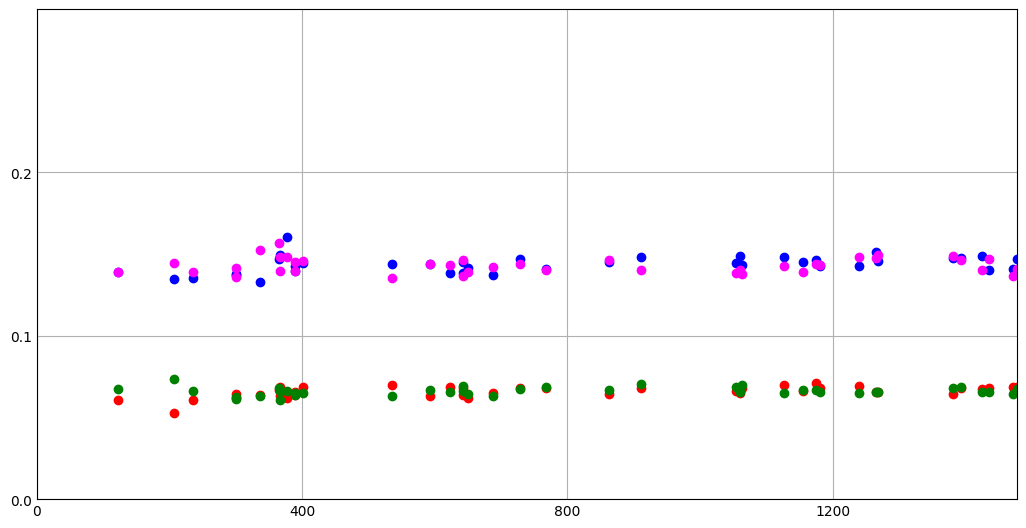

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x, y1, c="blue",)
ax.scatter(x, y2, c="magenta")
ax.scatter(x, y3, c="red")
ax.scatter(x, y4, c="green")

ax.set(xlim=(0, max(x)), xticks=np.arange(0,max(x), 400 ),
       ylim=(0, 0.3), yticks=np.arange(0, 0.3, 0.1))

plt.show()

In [18]:
min(y3)

0.014072748956469927

In [19]:
max(y3)

0.01942893945899532